### Problem Statement

A company has launched a new landing page with the expectation that it will improve
user conversion rates compared to the existing page. However, deploying a new design
globally requires time, cost, and potential risk. To make an informed decision, 
the company wants to test whether the new page truly outperforms the old one in
driving conversions, both overall and across different countries.

### Objective

The objective of this project is to evaluate whether introducing a new landing page leads 
to a higher user conversion rate compared to the existing page. Using A/B testing 
methods—including hypothesis testing, two-proportion z-test, bootstrap confidence intervals,
and country-level segmentation—the goal is to determine if the new design provides a statistically
significant improvement in conversions and to assess whether the effect varies across geographic regions.

### Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Loading file

In [2]:
df= pd.read_csv("C:/Users/Mohammad23.Alam/OneDrive - Reliance Corporate IT Park Limited/Desktop/Projects/AB Testing/ab_test.csv")

In [3]:
df_countries= pd.read_csv("C:/Users/Mohammad23.Alam/OneDrive - Reliance Corporate IT Park Limited/Desktop/Projects/AB Testing/countries_ab.csv")

In [4]:
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


### Data Cleaning and preprocessing

In [5]:
# Renaming the column name
df.columns= ["user_id", "timestamp", "group", "landing_page", "converted"]

In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [7]:
print(f'Number of rows:{df.shape[0]}')
print(f'Number of unique users: {df.user_id.nunique()}')

Number of rows:294478
Number of unique users: 290584


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [17]:
# Missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [18]:
n_treat = df["group"].value_counts()
n_treat

group
treatment    147276
control      147202
Name: count, dtype: int64

In [19]:
# Need to check whether all treatment group assigned to new page or not 
n_treat = df["group"].value_counts()["treatment"]
n_new_page= df["landing_page"].value_counts()["new_page"]
difference= n_treat - n_new_page

pd.DataFrame(
    {
        'N treat':[n_treat],
        'N new page': [n_new_page],
        'Difference' : [difference]
    }
)

,N treat,N new page,Difference
0,147276,147239,37


Clearly we can see there is mismatch in the number of assigned users to treatment group and those landing on new page.
So, further exploration required.

In [20]:
# Checking only those rows
df[(df['group']== "treatment") & (df['landing_page']== "old_page")]


,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [21]:
# Creating a dataframe to identify mismatch

df_mismatch = df[
    ((df["group"] == "treatment") & (df["landing_page"] == "old_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "new_page"))
]

n_mismatch = df_mismatch.shape[0]
mismatch_percent = round(n_mismatch / len(df) * 100, 2)

print(f'Number of mismatch rows: {n_mismatch} rows')
print(f'Percent of mismatch rows: {mismatch_percent}%')


Number of mismatch rows: 3893 rows
Percent of mismatch rows: 1.32%


As one can see there are 3893 rows that are mismatch. So, we need to create a new dataframe.

In [22]:
df2= df[
       ((df["group"]=="control") & (df["landing_page"]=="old_page")) |
       ((df["group"]=="treatment") & (df["landing_page"]=="new_page"))
]
len(df2)

290585

In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [24]:
### Recheck mismatch
df2[(df2["group"]=="control") & (df2["landing_page"]=="new_page")].shape[0]

0

In [25]:
# Checking any duplicate entries
df2.user_id.nunique()

290584

In [26]:
len(df2)- df2.user_id.nunique()

1

In [27]:
# Identifying duplicate
df2[df2.duplicated("user_id")==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [28]:
# Dropping the duplicate
df2= df2.drop_duplicates("user_id")

In [29]:
len(df2)-df2.user_id.nunique()

0

### Probability

In [30]:
df2.converted.mean()*100

11.959708724499627

Irrespective of the group the users have been assigned and they land on the landing page,
there is ~ 12% probability of getting converted

In [31]:
# Conversion rates in both group
conversion_rate= df2.groupby("group")["converted"].mean() * 100
print(conversion_rate)

group
control      12.038630
treatment    11.880807
Name: converted, dtype: float64


In [32]:
pd.DataFrame(df2.landing_page.value_counts(normalize=True) *100)

,proportion
landing_page,
new_page,50.006194
old_page,49.993806


Observation:
(i). The probability of a user get converted when they are in control group is 12% 
     whereas for treatment it's about 11.88%
(ii). The percentage of user landing on new page is 50% whereas almost 50% is landing
     on new page.

So, there is no sufficient evidence to conclude.        
     

### A/B Testing

In order to perform A/B testing, we have to create sample by resampling with replacement method (Bootstrap method)

In [33]:
# Since number of iterations is 10000, it will take 10-15 min to execute. So, we need to check execution time
import time

start = time.time()
means_diff = []
size = df.shape[0]

for _ in range(10000):
    sample = df2.sample(size, replace=True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)
    
end = time.time()
print(f"Execution time: {end - start:.2f} seconds")

Execution time: 782.81 seconds


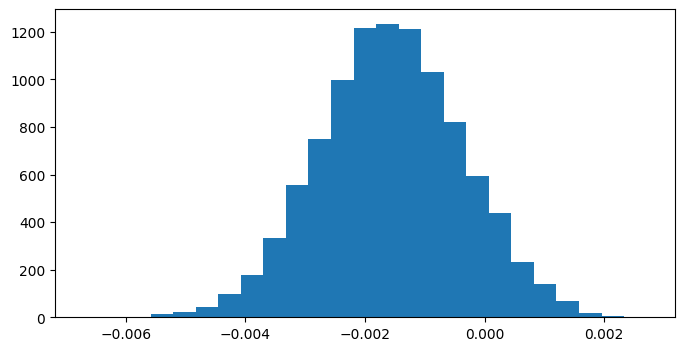

In [34]:
# Plotting the sampling distribution 
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

The distribution is centered around slightly negative values (around -0.0015 to -0.002).
This means that, on average, the treatment group converts a bit less than the control group.

No strong evidence that the treatment (new page) outperforms the control (old page).
If anything, the treatment is slightly worse (since the center is negative), but the difference
is not statistically significant because 0 lies inside the distribution.
In practical terms → the new landing page does not appear to improve conversions, so we cannot recommend rolling it out.

In [35]:
# Simulating distribution under the null hypothesis
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

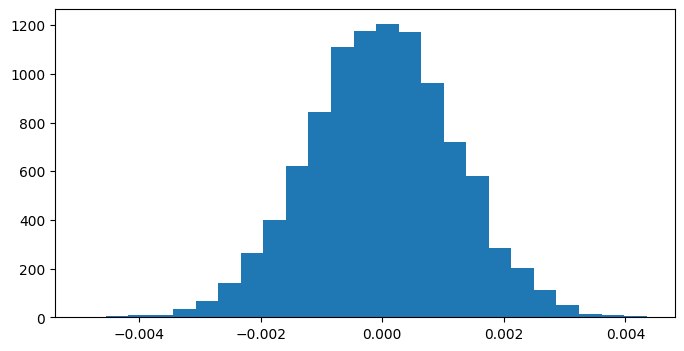

In [36]:
# Plot the null distribution
plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

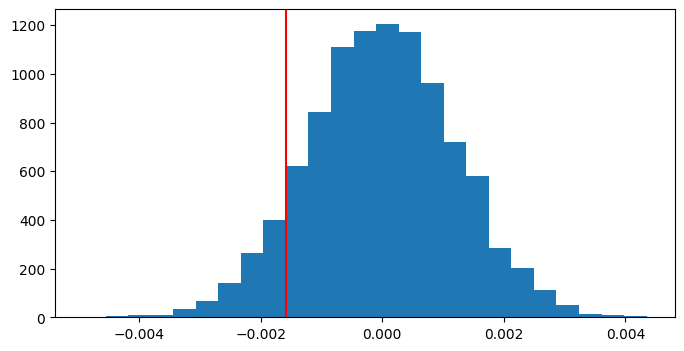

In [37]:
# Plot observed statistic with the null distibution
control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

In [38]:
# calculating the p value 
(null_vals > obs_diff).mean()

0.9057

A p-value of 0.9098 means:
If the null hypothesis (no difference between old and new page) were true, there is a 90.98% 
chance of observing a difference as extreme (or more extreme) than what you saw.
You fail to reject the null hypothesis.
The observed difference between treatment (new page) and control (old page) is completely consistent with random chance.
In fact, it strongly suggests that the new landing page did not improve conversions (and might even be slightly worse).

### Two Proportion Z-Test

In [39]:
!pip install scipy --upgrade --quiet


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import numpy as np
from scipy.stats import norm

In [41]:
# Step 1: Counts and sizes
convert_control = df2[df2["group"]=="control"]["converted"].sum()
convert_treat = df2[df2["group"]=="treatment"]["converted"].sum()

n_control = df2[df2["group"]=="control"].shape[0]
n_treat = df2[df2["group"]=="treatment"].shape[0]

# Step 2: Conversion rates
p_control = convert_control / n_control
p_treat = convert_treat / n_treat
obs_diff = p_treat - p_control

# Step 3: Pooled proportion (pooled rate)
p_pool = (convert_control + convert_treat) / (n_control + n_treat)

# Step 4: Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treat))

# Step 5: Z-statistic
z_stat = obs_diff / se

# Step 6: P-value (two-tailed)
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

# Print results clearly
print(f"Control Conversion Rate: {p_control:.4f}")
print(f"Treatment Conversion Rate: {p_treat:.4f}")
print(f"Observed Difference: {obs_diff:.4f}")
print(f"Pooled Conversion Rate: {p_pool:.4f}")
print(f"Standard Error: {se:.4f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Control Conversion Rate: 0.1204
Treatment Conversion Rate: 0.1188
Observed Difference: -0.0016
Pooled Conversion Rate: 0.1196
Standard Error: 0.0012
Z-statistic: -1.3109
P-value: 0.1899


The new page performed slightly worse (–0.16 pp), but the difference is not statistically significant (p > 0.05).
Evidence is insufficient to conclude the new page improves conversion.
Rolling out the new page globally is not recommended at this stage.
Consider further testing (segmentation by country/device) before making rollout decisions.

### Bootstrap Confidence Interval

In [42]:
ci_low, ci_high = np.percentile(means_diff, [2.5, 97.5])
print(f"95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

95% Confidence Interval: [-0.0039, 0.0008]


The true difference in conversion rates (Treatment – Control) is likely between
–0.39 percentage points and +0.08 percentage points.
Since the interval crosses 0, the effect is not statistically significant.
Treatment could be slightly worse (–0.39%) Or slightly better (+0.08%)
We cannot be confident about either.

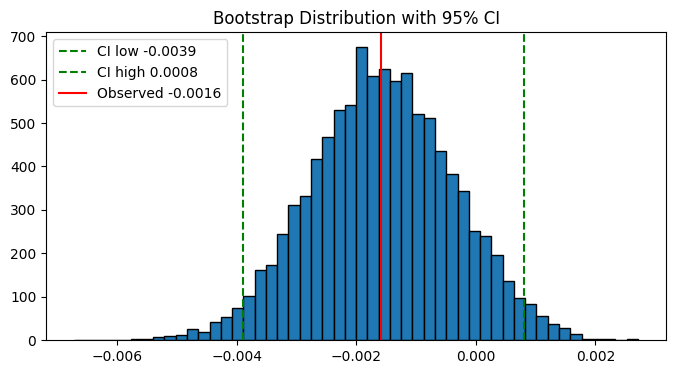

In [46]:
# Visualization
plt.figure(figsize=(8,4))
plt.hist(means_diff, bins=50, edgecolor='black')
plt.axvline(ci_low, color='green', linestyle='--', label=f'CI low {ci_low:.4f}')
plt.axvline(ci_high, color='green', linestyle='--', label=f'CI high {ci_high:.4f}')
plt.axvline(obs_diff, color='red', linestyle='-', label=f'Observed {obs_diff:.4f}')
plt.legend()
plt.title("Bootstrap Distribution with 95% CI")
plt.show()


The new page has no statistically significant effect on conversion. At best, it improves by +0.08%, and at worst,
reduces by –0.39%. Since the possible gain is below business relevance, global rollout is not justified.

### Geographic Segmentation of A/B Test Results

In [53]:
# Joining both datasets
df_merged = df2.merge(df_countries, left_on="user_id", right_on="id", how="left")
df_merged.drop("id", axis=1, inplace=True)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [54]:
# Conversion by country and group
df_merged.groupby(["country", "group"])["converted"].mean().unstack()

group,control,treatment
country,,
CA,0.118783,0.111902
UK,0.120022,0.121171
US,0.120630,0.118466


In [56]:
!pip install statsmodels --upgrade --quiet


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
# Hypothesis Testing per Country (Mini A/B tests)
from statsmodels.stats.proportion import proportions_ztest

rows = []
for ctry, sub in df_merged.groupby("country"):
    if sub["group"].nunique() < 2:  # skip if only one group present
        continue
    x_treat = sub[sub["group"]=="treatment"]["converted"].sum()
    n_treat = sub[sub["group"]=="treatment"]["converted"].count()
    x_control = sub[sub["group"]=="control"]["converted"].sum()
    n_control = sub[sub["group"]=="control"]["converted"].count()
    
    z, pval = proportions_ztest([x_treat, x_control], [n_treat, n_control])
    rows.append([ctry, x_treat/n_treat, x_control/n_control, (x_treat/n_treat - x_control/n_control), pval])

country_results = pd.DataFrame(rows, columns=["country","treat_rate","control_rate","diff","pval"])
print(country_results)


  country  treat_rate  control_rate      diff      pval
0      CA    0.111902      0.118783 -0.006881  0.194666
1      UK    0.121171      0.120022  0.001149  0.634865
2      US    0.118466      0.120630 -0.002164  0.132274


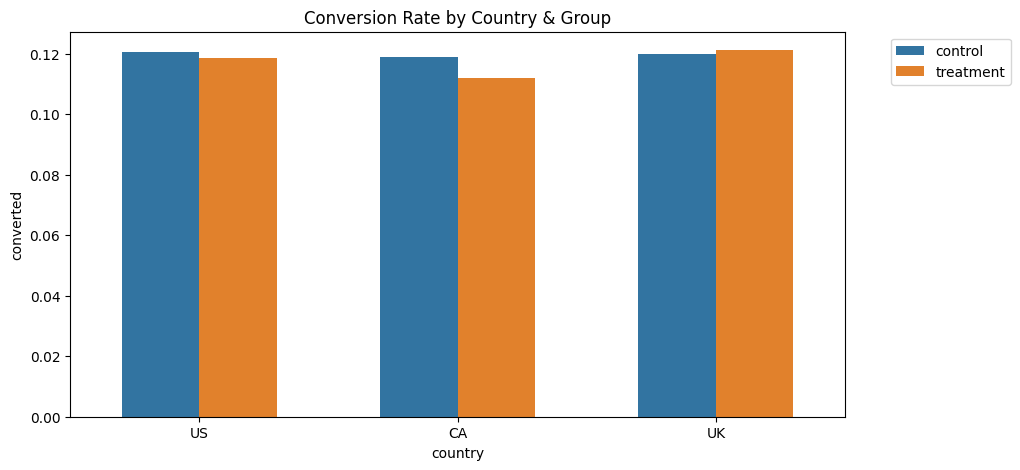

In [67]:
#Visualization
plt.figure(figsize=(10,5))
sns.barplot(data=df_merged, x="country", y="converted", hue="group", width=0.6, errorbar=None)
plt.legend(loc="upper right")
plt.title("Conversion Rate by Country & Group")
# Move legend outside the plot (right side)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In all three countries (US, CA, UK), the treatment (orange) and control (blue) bars are almost the same height.
This visually confirms what we saw in hypothesis testing: no major difference in conversion rates.
Across all countries, treatment does not significantly outperform control.
Any observed differences are small and likely due to random chance.

### Regression with Interaction

In [68]:
import statsmodels.formula.api as smf

df_merged["is_treatment"] = (df_merged["group"]=="treatment").astype(int)

model = smf.logit("converted ~ is_treatment * C(country)", data=df_merged).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 07 Sep 2025   Pseudo R-squ.:               3.482e-05
Time:                        14:28:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.0040      0.036    -55.008      0.

Baseline conversion rate (control group in baseline country) ≈ 11.9%.
Treatment has no statistically significant effect on conversion (p>0.05).
Country also does not significantly affect conversion.
Interaction terms show treatment effect is similar across countries.

### Final Conclusion

The A/B test results show that the new landing page does not provide a statistically significant
improvement in conversion rates compared to the existing page.
1. Hypothesis testing & two-proportion z-test: P-values were much higher than 0.05, meaning we cannot 
reject the null hypothesis of “no difference.”
2. Bootstrap confidence intervals: The 95% CI for the difference in conversion rates included zero, 
confirming that the new page may slightly improve or worsen conversions, but not in a meaningful way.
3. Country-level analysis: Across the US, UK, and Canada, conversion rates between treatment and control
were very close, with no country showing a significant treatment effect.

### Business Recommendation
The new page design does not show meaningful improvement in any country. 
A global rollout is not justified based on the evidence. Focus should be on further testing
with new design variations or targeting different user segments.